# AdaDelta local optimiser

XXXXXXXXXXXXxx

## Example 1: finding the bottom of a parabolic valley

As a first test we optimise on a parabola, centered at the origin:

In [1]:
import pints
import pints.toy

# Create a parabolic error function
error = pints.toy.ParabolicError()

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the error function on a grid of points
X = np.arange(-2, 2.1, 0.1)
Y = np.arange(-1, 1.1, 0.1)
Z = np.zeros((len(Y), len(X)))
for i, x in enumerate(X):
    for j, y in enumerate(Y):
        Z[j, i] = error((x, y))
X, Y = np.meshgrid(X, Y)

# Define a function to create a contour plot
def create_contour_plot():

    # Create figure
    fig = plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 1, 1)
    ax.set_aspect('equal')
    plt.xlim(-2, 2)
    plt.ylim(-1, 1)

    # Plot the contours
    plt.contour(X, Y, Z, levels=20)
    
    # Show where the optimum is
    plt.plot([0], [0], 'x', color='red', label='optimum', markersize=20)

We choose a starting point and make a plot:

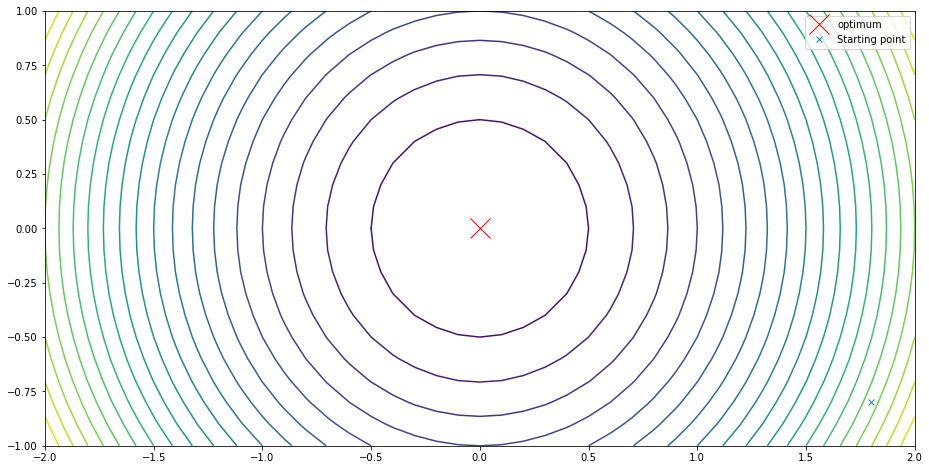

In [3]:
# Create a contour plot
create_contour_plot()

# Choose a starting point for the optimisation
x0 = [1.8, -0.8]

# Show the starting point
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Show the whole figure
plt.legend()
plt.show()

Now we create an optimiser and use the ask-and-tell interface to let it walk a few steps.
The step size will be set using the `sigma0` parameter:

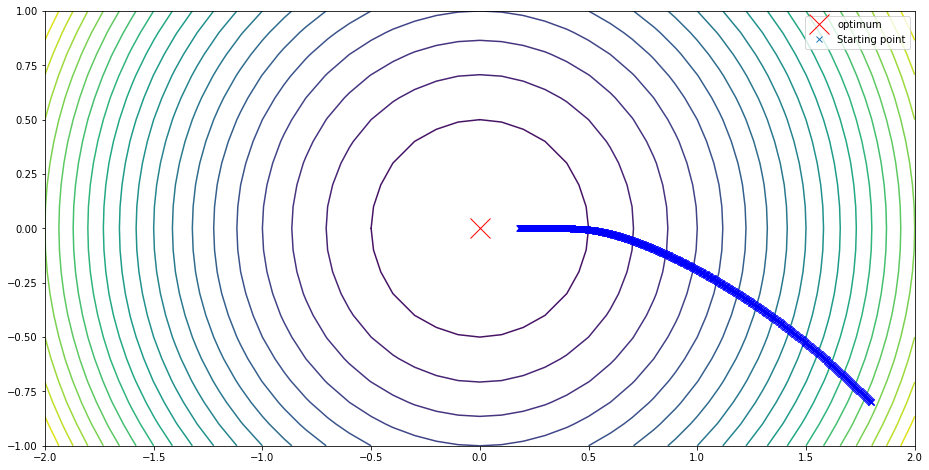

In [4]:
# Create a nice plot
create_contour_plot()
plt.plot(x0[0], x0[1], 'x', label='Starting point')

# Create an optimiser
opt = pints.AdaDelta(x0)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(500):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

ZZZZZZZZZZZZZZZZZZZZzz

## Example 2: Maximising a difficult LogPDF

We now try this method on the ["banana" twisted gaussian LogPDF](https://pints.readthedocs.io/en/latest/toy/twisted_gaussian_logpdf.html) (wrapped in a [ProbabilityBasedError](https://pints.readthedocs.io/en/latest/error_measures.html#pints.ProbabilityBasedError)).

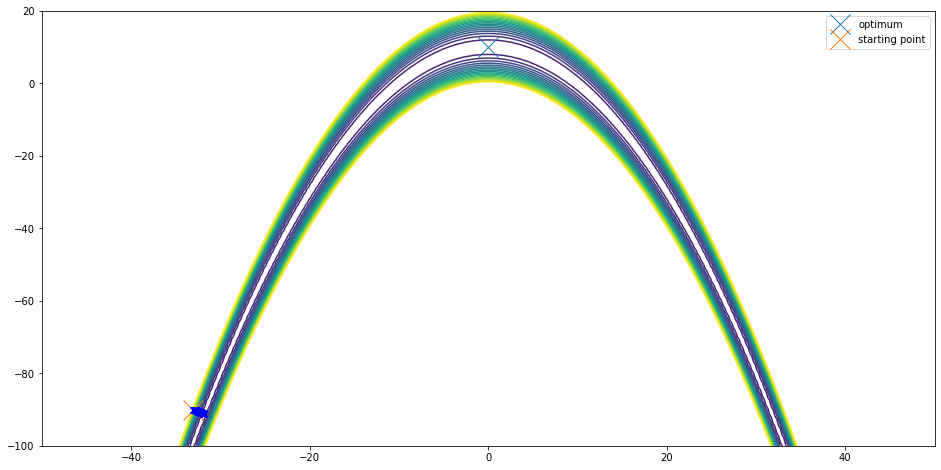

In [22]:
# Define a LogPDF (a 2-dimensional twisted gaussian)
logpdf = pints.toy.TwistedGaussianLogPDF(dimension=2)

# Wrap an error around the LogPDF
error = pints.ProbabilityBasedError(logpdf)

# Create figure
fig = plt.figure(figsize=(16, 8))
ax = plt.subplot(1, 1, 1)
plt.xlim(-50, 50)
plt.ylim(-100, 20)

# Evaluate the error function on a grid of points
levels = np.linspace(1, 50, 20)
x = np.linspace(-50, 50, 250)
y = np.linspace(-100, 20, 250)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]
plt.contour(X, Y, Z, levels=levels)

# Show the optimum
plt.plot(0, 10, 'x', markersize=20, label='optimum')

# Pick a starting point
x0 = [-33, -90]
plt.plot(x0[0], x0[1], 'x', markersize=20, label='starting point')

# Create an optimiser
opt = pints.AdaDelta(x0)

# Create an evaluator to evaluate the error function
# Because this method requires gradients, we must pass in the EvaluateS1 function
e = pints.SequentialEvaluator(error.evaluateS1)

# Walk a few steps, and plot the results
x1 = x0
for i in range(1000):
    xs = opt.ask()
    fs = e.evaluate(xs)
    opt.tell(fs)
    
    x2 = xs[0]
    plt.plot((x1[0], x2[0]), (x1[1], x2[1]), 'x-', color='blue')
    x1 = x2

# Show the whole figure
plt.legend()
plt.show()

RRRRRRRRRRRRRRRRRRRRRRRRRRR

## Example 3: A noisy time-series problem

Finally, we apply this method to a noisy time series problem:

In [18]:
#transformation = pints.ScalingTransformation([1 / 50, 500])
transformation = pints.ScalingTransformation([50, 1 / 500])

# Load a forward model
model = pints.toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
values = model.simulate(real_parameters, times)

# Add noise
values += np.random.normal(0, 10, values.shape)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [0.01, 450]
opt = pints.OptimisationController(
    score,
    x0,
    transformation=transformation,
    method=pints.AdaDelta
)
opt.set_max_iterations(1e7)
opt.set_log_interval(1e4)
found_parameters, found_value = opt.run()

# Show score of true solution
print('Score at true solution: ')
print(score(real_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Minimising error measure
Using Adam
Running in sequential mode.
Iter.   Eval.   Best      Current   Time m:s
0       1        1.91e+07  1.91e+07   0:00.0
1       2        1.82e+07  1.82e+07   0:00.0
2       3        1.74e+07  1.74e+07   0:00.0
3       4        1.65e+07  1.65e+07   0:00.0
468     468      105879.9  129597.1   0:00.1
Halting: No significant change for 200 iterations.
Score at true solution: 
106226.96290913576
Found solution:          True parameters:
 1.49908638869521507e-02     1.49999999999999994e-02
 4.99301987934475619e+02     5.00000000000000000e+02
